# Linear Regression on to a Climate Index

This notebook shows a relatively easy implementation for linear regression across spatial points on to a single time series like some climate index.

In [2]:
#
# Construct a "climate index" and then find the regression coefficient at all locations
#
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Monthly 2m air temperature anomalies
ds = xr.open_dataset("/Users/brianpm/Library/CloudStorage/Dropbox/Data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc")

ds = ds.rename({"latitude":"lat", "longitude":"lon"})
# note lon is -180 to 180
ds

<xarray.Dataset>
Dimensions:           (time: 2077, lat: 36, lon: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-01-1...
  * lat               (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon               (lon) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, lat, lon) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (lat, bnds) float64 ...
    longitude_bnds    (lon, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2023-03-13T12:56:52+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

In [4]:
# simple ENSO index
nino34sst = ds['tas_mean'].sel(lat=slice(-5,5), lon=slice(-170,-120))
nino34sst = nino34sst.weighted(np.cos(np.radians(nino34sst.lat))).mean(dim=("lat","lon")).compute()
nino34sst_30yr = nino34sst.rolling(time=30*12, center=True).mean().compute()
oni = (nino34sst - nino34sst_30yr).rolling(time=3).mean()
elnino = xr.where(oni > 0.5, oni, np.nan)


In [5]:

# take subset that doesn't have missing values in ONI 
# this is just to illustrate the calculation
oni_sub = oni.sel(time=slice("1940-01-01","2000-01-01"))
ds_sub = ds.sel(time=slice("1940-01-01","2000-01-01"))

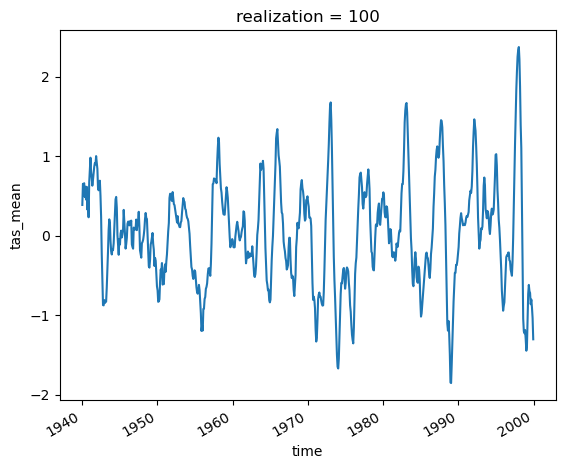

In [6]:
# Quick look at the time series of ONI
oni_sub.plot()

Text(0.5, 1.0, 'Eastern Equatorial Pacific')

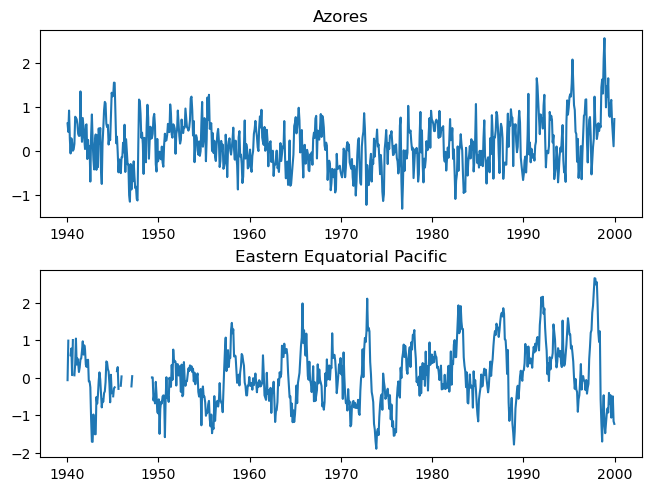

In [13]:
# now let's find the regression of some arbitrary point against our ONI series
azores = ds_sub.sel(lat=37.7, lon=-25.6, method='nearest')

epac = ds_sub.sel(lat=2, lon=-150, method='nearest')

# Quick look at the time series at this point
fig, ax = plt.subplots(nrows=2, constrained_layout=True)
ax[0].plot(ds_sub.time.dt.year + ds_sub.time.dt.dayofyear/365, azores['tas_mean'])
ax[0].set_title("Azores")
ax[1].plot(ds_sub.time.dt.year + ds_sub.time.dt.dayofyear/365, epac['tas_mean'])
ax[1].set_title("Eastern Equatorial Pacific")


In [14]:
# individual least squares fit
fit = np.linalg.lstsq(np.vstack([oni_sub.values, np.ones(len(oni_sub.values))]).T, azores['tas_mean'].values, rcond=None)

fit2 = np.linalg.lstsq(np.vstack([oni_sub.values, np.ones(len(oni_sub.values))]).T, epac['tas_mean'].values, rcond=None)

Text(0.5, 1.0, 'Eastern Equatorial Pacific')

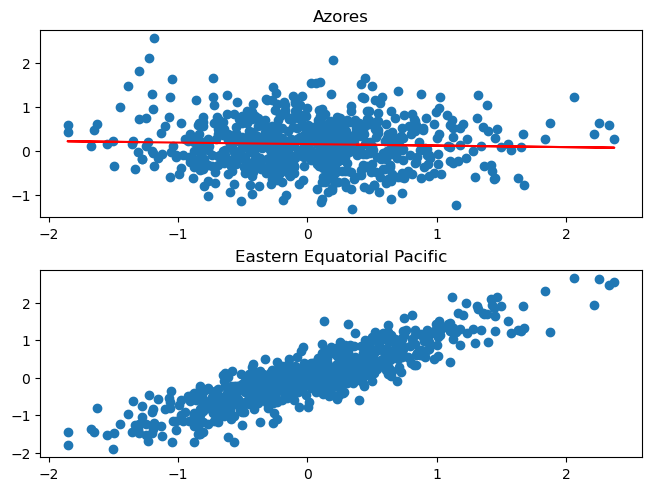

In [15]:
# Take a look at the linear fit through the scatter plot
fig, ax = plt.subplots(nrows=2, constrained_layout=True)
timeaxis = oni_sub.time.dt.year + oni_sub.time.dt.dayofyear/365
ax[0].scatter(oni_sub, azores['tas_mean'])
ax[0].plot(oni_sub, fit[0][0]*oni_sub + fit[0][1], color='red')
ax[0].set_title("Azores")

ax[1].scatter(oni_sub, epac['tas_mean'])
ax[1].plot(oni_sub, fit2[0][0]*oni_sub + fit2[0][1], color='red')
ax[1].set_title("Eastern Equatorial Pacific")

# In this example, the fit fails because of missing data.


In [18]:
# To deal with missing data, mask them out
epac_valid = ~np.isnan(epac['tas_mean'])

fit2 = np.linalg.lstsq(np.vstack([oni_sub.values[epac_valid], np.ones(len(oni_sub.values[epac_valid]))]).T, 
                       epac['tas_mean'].values[epac_valid], rcond=None)

Text(0.5, 1.0, 'Eastern Equatorial Pacific')

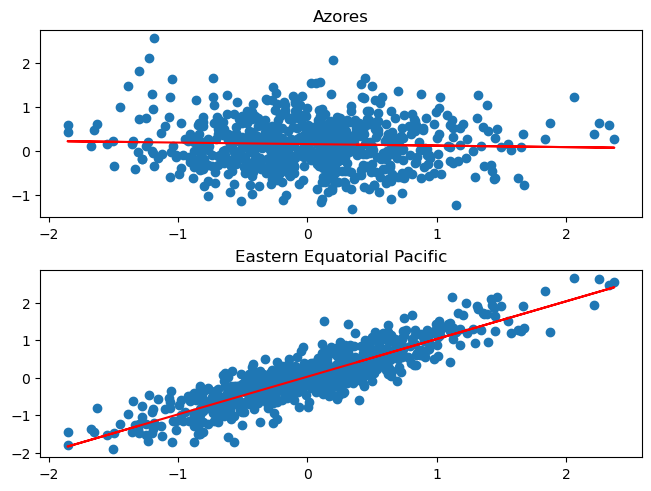

In [19]:
# Take a look at the linear fit through the scatter plot
fig, ax = plt.subplots(nrows=2, constrained_layout=True)
timeaxis = oni_sub.time.dt.year + oni_sub.time.dt.dayofyear/365
ax[0].scatter(oni_sub, azores['tas_mean'])
ax[0].plot(oni_sub, fit[0][0]*oni_sub + fit[0][1], color='red')
ax[0].set_title("Azores")

ax[1].scatter(oni_sub, epac['tas_mean'])
ax[1].plot(oni_sub, fit2[0][0]*oni_sub + fit2[0][1], color='red')
ax[1].set_title("Eastern Equatorial Pacific")


In [28]:
%%time
#
# Apply similar fit to all locations
#

ds_stack = ds_sub.stack(z=("lat","lon")) # "stack" the spatial dimensions into a single dimension

d_standardized = data_standardized = (ds_stack['tas_mean'] - ds_stack['tas_mean'].mean(dim='time'))/ds_stack['tas_mean'].std(dim='time')

fits = np.linalg.lstsq(np.vstack([oni_sub.values, np.ones(len(oni_sub.values))]).T,
                       d_standardized.values,
                       rcond=None)

CPU times: user 27.1 ms, sys: 6.65 ms, total: 33.8 ms
Wall time: 33.5 ms


In [29]:
print(fits[0].shape)

# put the regression coefficient (slope) into DataArray
rcoef = xr.DataArray(fits[0][0,:], coords={'z':ds_stack['z']})
rcoef = rcoef.unstack()

(2, 2592)


In [30]:
fits[0][0,:]

array([        nan,         nan,         nan, ..., -0.1173679 ,
       -0.11532041, -0.11335529])

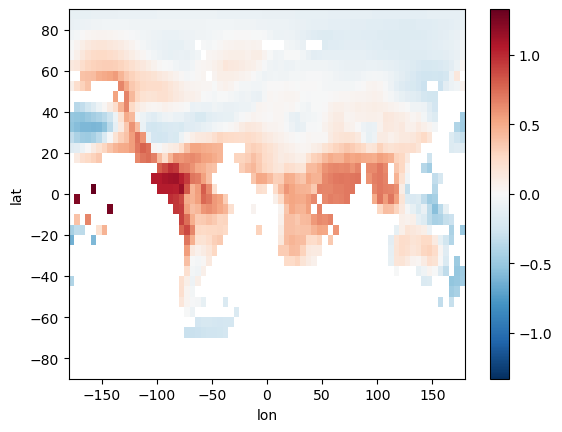

In [32]:
# quick look at the regression coefficients
rcoef.plot.pcolormesh()

In [25]:
# so how to mask the missing values efficiently?
data_valid = ~np.isnan(ds_stack['tas_mean'])
data_valid

<xarray.DataArray 'tas_mean' (time: 720, z: 2592)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * time         (time) datetime64[ns] 1940-01-16T12:00:00 ... 1999-12-16T12:...
    realization  int64 ...
  * z            (z) object MultiIndex
  * lat          (z) float64 -87.5 -87.5 -87.5 -87.5 ... 87.5 87.5 87.5 87.5
  * lon          (z) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

In [26]:
oni_sub_conditional = oni_sub.broadcast_like(data_valid)
fits = np.linalg.lstsq(np.vstack([oni_sub_conditional.values[data_valid], np.ones(len(oni_sub.values))]).T,
                       ds_stack['tas_mean'].values[data_valid],
                       rcond=None)

In [70]:
#
# JUSTIN START HERE!!!!
#
ds1 = xr.open_mfdataset("/Users/brianpm/Desktop/b.e11.B20TRC5CNBDRD.f09_g16.001.cam.h0.PSL.*.nc", decode_times=False)
ctime = ds1['time_bnds'].mean(dim='nbnd')
ctime.attrs = ds1['time'].attrs
ds1 = ds1.assign_coords({"time":ctime})
ds1 = xr.decode_cf(ds1)
ds1
psl = (ds1['PSL'] / 100.).compute()


In [72]:
psl_anom = psl.groupby('time.month') - psl.groupby('time.month').mean(dim='time')
arrU = psl_anom.rolling(time=5, center=True).mean(dim='time')
arrU = arrU.ffill(dim='time').bfill(dim='time').compute()
arr_ndjfm = arrU.isel( time=slice(0, None, 12))
npi_ndjfm = arr_ndjfm.sel(lat=slice(30,65), lon=slice(160,220))
npi_ndjfm = npi_ndjfm.weighted(np.cos(np.radians(npi_ndjfm.lat))).mean(dim=('lat','lon'))

/var/folders/3y/4dzlw6yj5bj8ds39vpvyg92m0000gp/T/ipykernel_59746/1444577519.py:2: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  arrU = psl_anom.rolling(time=5, center=True).mean(dim='time')


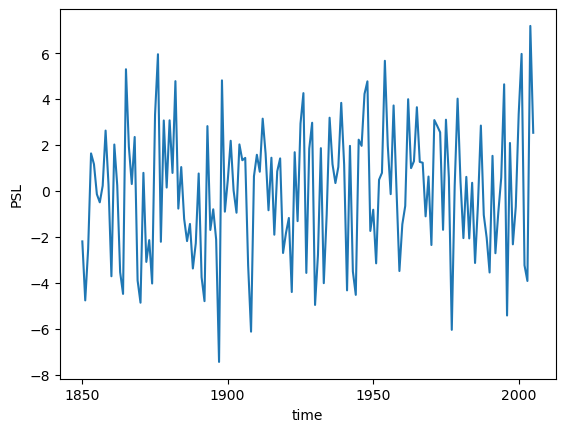

In [73]:
npi_ndjfm.plot()

In [74]:
npi_ndjfm_standarized = (npi_ndjfm - npi_ndjfm.mean(dim='time'))/npi_ndjfm.std(dim='time')

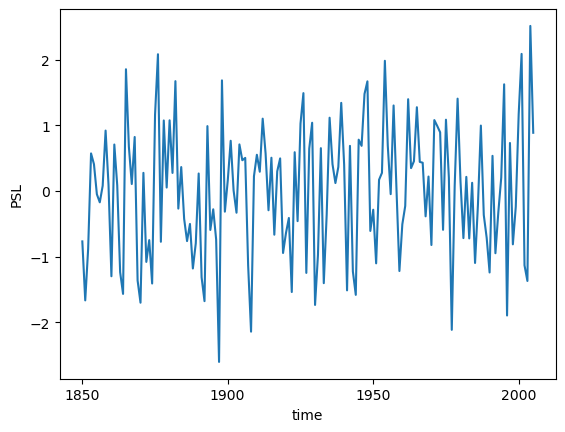

In [75]:
npi_ndjfm_standarized.plot()

In [76]:
arr_ndjfm = arr_ndjfm.stack(z=("lat","lon"))
fits = np.linalg.lstsq(np.vstack([npi_ndjfm_standarized, np.ones(len(npi_ndjfm_standarized.values))]).T,
                       arr_ndjfm.values,
                       rcond=None)

In [77]:

# put the regression coefficient (slope) into DataArray
rcoef = xr.DataArray(fits[0][0,:], coords={'z':arr_ndjfm['z']})
rcoef = rcoef.unstack()

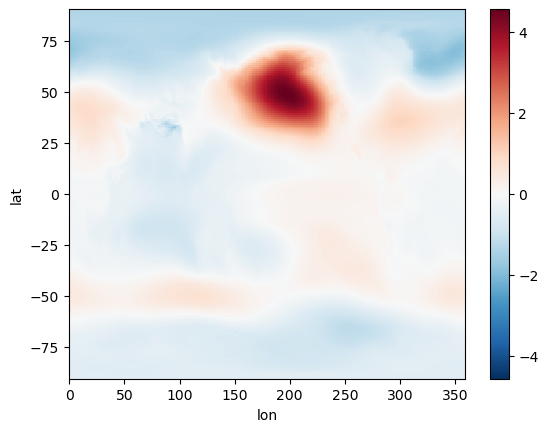

In [78]:
rcoef.plot.pcolormesh()

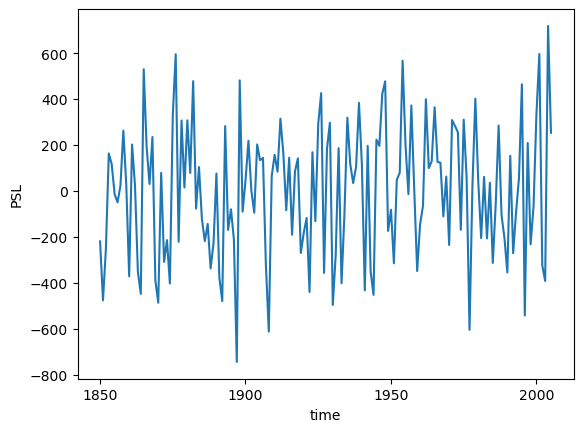

In [69]:
npi_ndjfm.plot()

In [80]:
rcoef.min()

<xarray.DataArray ()>
array(-1.9624753)